In [ ]:
import pandas as pd
import os
import torch
from PIL import Image
import requests
import concurrent.futures as futures
import ast
import matplotlib.pyplot as plt
import io
import cv2
import matplotlib.patches as patches
import  os
import numpy as np


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
#To create root for the test and train images to store
root = '/content/drive/MyDrive/Dataset/'

In [ ]:
#To mount the google drive to collab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!rm -r 'data'

In [ ]:
#To split the whole dataset as for training and testing dataset
rootPth = 'data'
os.mkdir(rootPth)

os.mkdir(rootPth +'/train')
os.mkdir(rootPth +'/train/images')
os.mkdir(rootPth +'/train/labels')

os.mkdir(rootPth +'/test')
os.mkdir(rootPth +'/test/images')
os.mkdir(rootPth +'/test/labels')

In [ ]:
#Filenames that are input images to yolo
import os

def get_filenames_without_label(directory):
  filenames = []
  for filename in os.listdir(directory):
    if not filename.endswith('label.jpg'):
      filenames.append(filename)
  return filenames

filenames = get_filenames_without_label(root)
filenames

['Image06.JPG',
 'Image17.JPG',
 'Image20.JPG',
 'Image18.JPG',
 'Image19.JPG',
 'Image14.JPG',
 'Image13.JPG',
 'Image16.JPG',
 'Image01.JPG',
 'Image02.JPG',
 'Image07.JPG',
 'Image03.JPG',
 'Image11.JPG',
 'Image05.JPG',
 'Image04.JPG',
 'Image10.JPG',
 'Image15.JPG',
 'Image08.JPG',
 'Image12.JPG',
 'Image09.JPG']

In [ ]:
import numpy as np
import cv2
from shapely.geometry import Polygon

def mask_to_polygons(img_path, mask_path):
    '''
    Converts a mask image to polygons. Returns two lists:
    - List of Shapely polygons without normalization
    - List of normalized Shapely polygons (coordinates between 0 and 1)

    Args:
        img_path (str): Path to the original image file.
        mask_path (str): Path to the grayscale mask file.
    '''

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Calculate contours
    mask = mask.astype(bool)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convert contours to Label Studio polygons
    polygons = []
    normalized_polygons = []
    for contour in contours:

        # Try-except block is used because the polygon extraction by OpenCV from the mask
        # sometimes generates polygons with fewer than 4 vertices, which are not closed,
        # causing failure when converting to a Shapely polygon

        try:
            polygon = contour.reshape(-1, 2).tolist()

            # Normalize coordinates between 0 and 1 as required by YOLOv8
            normalized_polygon = [[round(coord[0] / mask.shape[1] , 4), round(coord[1] / mask.shape[0] , 4)] for coord in polygon]

            # Convert to Shapely Polygon object (without normalization)
            polygon_shapely = Polygon(polygon)
            simplified_polygon = polygon_shapely.simplify(0.85, preserve_topology=True)
            polygons.append(simplified_polygon)

            # Normalized polygons
            normalized_polygons.append(Polygon(normalized_polygon))

        except Exception as e:
            pass

    return polygons, normalized_polygons


In [ ]:
test_image = 'Image10'

# Call the mask_to_polygons function to convert the mask image to polygons
poly, norm_poly = mask_to_polygons(root + f'/{test_image}.JPG', root + f'/{test_image}_label.jpg')


No of stones in the image is 40


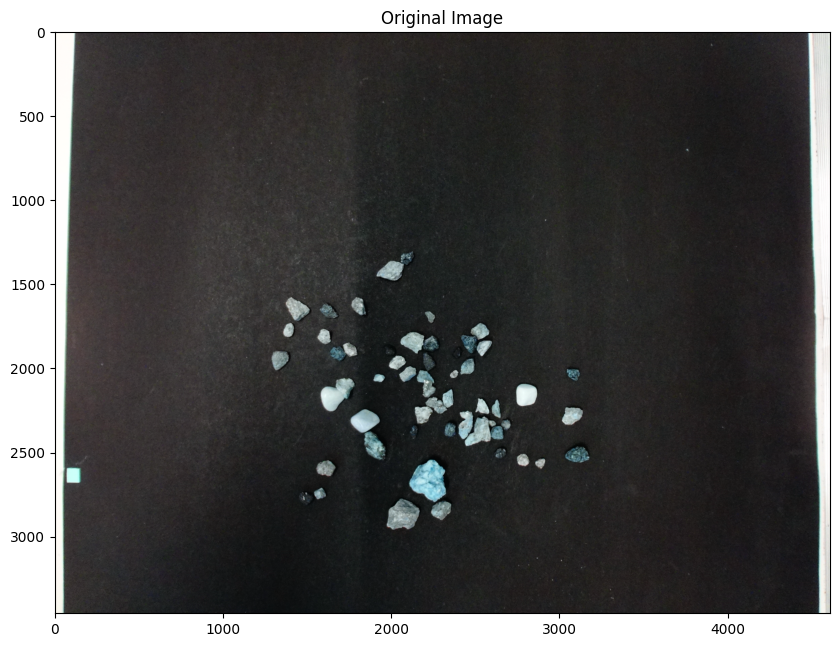

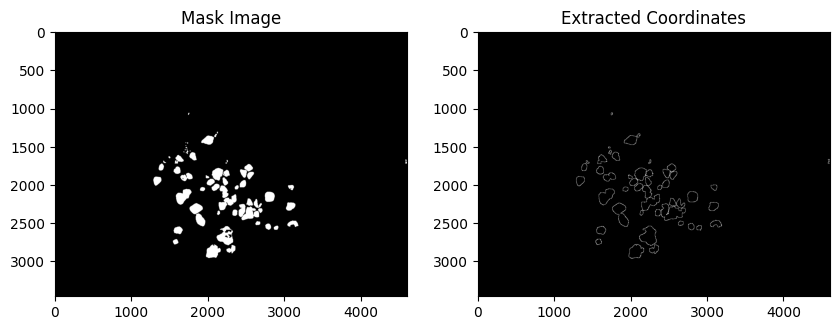

In [ ]:
# Load the mask image and the original image
mask_image = cv2.imread(root+f'/{test_image}_label.jpg')
original_image = cv2.imread(root+f'/{test_image}.JPG')

# Create a black image to plot the polygons
black_image = np.zeros_like(original_image)

cnt = 0
# Plot the polygons on the black image
for polygon in poly:
  x, y = polygon.exterior.xy
  if len(x) > 50:
    cnt += 1
    cv2.polylines(black_image, np.array([np.array(list(zip(x, y)))], dtype=np.int32), True, (255, 255, 255), 2)

print("No of stones in the image is",cnt)

# Display the images side by side
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(mask_image)
plt.title('Mask Image')
plt.subplot(1, 2, 2)
plt.imshow(black_image)
plt.title('Extracted Coordinates')
plt.show()


In [ ]:
def get_data(image_path, mask_path, flag='train'):
    try:
        # Define paths for saving images and labels
        image_file = 'data/{1}/images/{0}'.format(image_path, flag)
        image_txt = 'data/{1}/labels/{0}.txt'.format(image_path.split('.JPG')[0], flag)

        # Open the original image using Pillow
        image = Image.open(root + '/' + image_path)

        # Open a text file for writing label coordinates
        fp = open(image_txt, 'w')

        # Convert mask to polygons and get normalized polygons
        poly, norm_poly = mask_to_polygons(root + '/' + image_path, root + '/' + mask_path)

        # Counter for valid polygons with more than 50 vertices
        cnt = 0

        # Iterate over normalized polygons
        for polygon in norm_poly:
            poly_coor = '0 '  # Initialize the label string with class index (0 for now)
            x, y = polygon.exterior.xy  # Get x, y coordinates of the polygon
            x = np.array(x)
            y = np.array(y)

            # Check if the polygon has more than 50 vertices
            if len(x) > 50:
                cnt += 1

                # Append polygon coordinates to the label string
                for iter in range(len(x)):
                    poly_coor += str(x[iter]) + ' '
                    poly_coor += str(y[iter]) + ' '

                poly_coor += '\n'  # Add newline character after each polygon
                fp.write(poly_coor)  # Write the label string to the text file

        image.save(image_file)  # Save the modified image with annotations

        print(image_txt, cnt)  # Print the label file path and the number of valid polygons

    except Exception as e:
        print(e)  # Print any exceptions that occur during processing


In [ ]:
# Iterate over the first 18 filenames in the list 'filenames'
for i in filenames[:18]:
    # Call the get_data function for each filename in the list
    # Replace '.JPG' with '_label.jpg' in the mask path to get the corresponding mask filename
    get_data(i, i.replace('.JPG', '_label.jpg'))


data/train/labels/Image06.txt 49
data/train/labels/Image17.txt 53
data/train/labels/Image20.txt 47
data/train/labels/Image18.txt 55
data/train/labels/Image19.txt 49
data/train/labels/Image14.txt 52
data/train/labels/Image13.txt 49
data/train/labels/Image16.txt 48
data/train/labels/Image01.txt 21
data/train/labels/Image02.txt 7
data/train/labels/Image07.txt 66
data/train/labels/Image03.txt 22
data/train/labels/Image11.txt 46
data/train/labels/Image05.txt 12
data/train/labels/Image04.txt 10
data/train/labels/Image10.txt 48
data/train/labels/Image15.txt 52
data/train/labels/Image08.txt 50


In [ ]:
# Iterate over filenames starting from the 18th index until the end of the list 'filenames'
for i in filenames[18:]:
    # Call the get_data function for each filename in the remaining list
    # Replace '.JPG' with '_label.jpg' in the mask path to get the corresponding mask filename
    # Set the flag parameter to 'test' to indicate that these are test images
    get_data(i, i.replace('.JPG', '_label.jpg'), flag='test')


data/test/labels/Image12.txt 51
data/test/labels/Image09.txt 45


In [ ]:
import os

# Initialize a list to store image file paths
image_files = []

# Counter to track the number of valid image files
cnt = 0

# Iterate over files in the 'train/images/' directory
for filename in os.listdir(rootPth + '/train/images/'):
    # Check if the file has a valid image extension
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png") or filename.endswith(".JPG"):
        # Construct the path to the corresponding label text file
        image_txt = rootPth + '/train/labels/{0}.txt'.format(str(filename.split('/')[-1]).split('.')[0])

        # Check if the label text file exists
        if os.path.exists(image_txt):
            # Append the image file path to the list
            image_files.append(rootPth + "/train/images/" + filename)
            cnt += 1  # Increment the counter for valid image files

# Open the train.txt file for writing
with open(rootPth + "/train/train.txt", "w") as outfile:
    # Write each image file path to the train.txt file
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")  # Add a newline character after each image path

    # Close the train.txt file
    outfile.close()


In [ ]:
# Print the number of files in the 'train/labels/' directory
print(len(os.listdir(rootPth + '/train/labels/')))

# Print the number of files in the 'train/images/' directory
print(len(os.listdir(rootPth + '/train/images/')))

# Open the 'train.txt' file in read mode
with open(rootPth + "/train/train.txt", 'r') as fp:
    # Read all lines from the file and count the number of lines (i.e., the number of image file paths)
    x = len(fp.readlines())
    # Print the number of lines read from the file (number of image file paths)
    print(x)


18
18
18


In [ ]:
import os

# Initialize a list to store image file paths
image_files = []

# Counter to track the number of valid image files
cnt = 0

# Iterate over files in the 'test/images/' directory
for filename in os.listdir(rootPth + '/test/images/'):
    # Check if the file has a valid image extension
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png") or filename.endswith(".JPG"):
        # Construct the path to the corresponding label text file
        image_txt = rootPth + '/test/labels/{0}.txt'.format(str(filename.split('/')[-1]).split('.')[0])

        # Check if the label text file exists
        if os.path.exists(image_txt):
            # Append the image file path to the list
            image_files.append(rootPth + "/test/images/" + filename)
            cnt += 1  # Increment the counter for valid image files

# Open the test.txt file for writing
with open(rootPth + "/test/test.txt", "w") as outfile:
    # Write each image file path to the test.txt file
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")  # Add a newline character after each image path

    # Close the test.txt file
    outfile.close()


In [ ]:
# Print the number of files in the 'test/labels/' directory
print(len(os.listdir(rootPth + '/test/labels/')))

# Print the number of files in the 'test/images/' directory
print(len(os.listdir(rootPth + '/test/images/')))

# Open the 'test.txt' file in read mode
with open(rootPth + "/test/test.txt", 'r') as fp:
    # Read all lines from the file and count the number of lines (i.e., the number of image file paths)
    x = len(fp.readlines())
    # Print the number of lines read from the file (number of image file paths)
    print(x)


2
2
2


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.3/721.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from ultralytics import YOLO

# Initialize the YOLOv8 model using the specified checkpoint file
model = YOLO("yolov8n-seg.pt")


100%|██████████| 6.73M/6.73M [00:00<00:00, 192MB/s]


In [ ]:
# Train the YOLOv8 model using the specified data configuration, number of epochs, and image size
model.train(data="/content/data.yaml", epochs=100, imgsz=640)


Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

100%|██████████| 755k/755k [00:00<00:00, 81.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/data/train/labels... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<00:00, 81.02it/s]

train: New cache created: /content/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/test/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 62.81it/s]

val: New cache created: /content/data/test/labels.cache


Plotting labels to runs/segment/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/segment/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.587      2.783      3.648      1.046         95        640: 100%|██████████| 2/2 [00:42<00:00, 21.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all          2         96       0.01     0.0625    0.00562    0.00275      0.015     0.0938    0.00862    0.00415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.767      2.725      3.616     0.9963        132        640: 100%|██████████| 2/2 [00:34<00:00, 17.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]

                   all          2         96     0.0233      0.146      0.014    0.00659     0.0267      0.167     0.0174     0.0073



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.271      2.011      3.423     0.9008         70        640: 100%|██████████| 2/2 [00:27<00:00, 13.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all          2         96     0.0383       0.24     0.0338      0.015     0.0433      0.271     0.0424     0.0191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.417      1.814      3.104     0.9138         52        640: 100%|██████████| 2/2 [00:25<00:00, 12.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

                   all          2         96     0.0467      0.292     0.0522     0.0252       0.05      0.312     0.0581     0.0251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.661      2.211      2.808      0.921        200        640: 100%|██████████| 2/2 [00:28<00:00, 14.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all          2         96     0.0683      0.427     0.0928     0.0493     0.0767      0.479      0.109      0.052



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.527      2.047      2.313       0.93        137        640: 100%|██████████| 2/2 [00:26<00:00, 13.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all          2         96       0.08        0.5      0.123     0.0654     0.0917      0.573      0.149     0.0665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.493      1.927      1.656     0.9399         58        640: 100%|██████████| 2/2 [00:26<00:00, 13.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          2         96     0.0883      0.552      0.143     0.0712     0.0933      0.583       0.17     0.0799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.961      2.568       1.52       0.92        208        640: 100%|██████████| 2/2 [00:26<00:00, 13.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          2         96       0.09      0.562      0.185     0.0727      0.107      0.667      0.209     0.0991



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.473       1.86      1.193     0.8747        147        640: 100%|██████████| 2/2 [00:27<00:00, 13.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          2         96     0.0917      0.573       0.25      0.098      0.105      0.656      0.241      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.441      1.714      1.178     0.8798        157        640: 100%|██████████| 2/2 [00:24<00:00, 12.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all          2         96     0.0933      0.583      0.328      0.142      0.103      0.646      0.319      0.133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.468      1.971      1.127     0.8953        163        640: 100%|██████████| 2/2 [00:26<00:00, 13.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all          2         96        0.1      0.625       0.36      0.212      0.107      0.667      0.377      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.398      1.816      1.155      0.886        131        640: 100%|██████████| 2/2 [00:25<00:00, 12.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          2         96      0.102      0.635      0.405      0.255      0.108      0.677      0.418      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G       1.41       2.24      1.344     0.9022         86        640: 100%|██████████| 2/2 [00:27<00:00, 13.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          2         96      0.107      0.667      0.406      0.254      0.112      0.698      0.421      0.212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.378      1.828      1.032      0.911        166        640: 100%|██████████| 2/2 [00:26<00:00, 13.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

                   all          2         96      0.107      0.667       0.39      0.235      0.105      0.656      0.369       0.18



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.353      1.697      1.068     0.9198         67        640: 100%|██████████| 2/2 [00:27<00:00, 13.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

                   all          2         96      0.112      0.698      0.381      0.224      0.103      0.646      0.381      0.172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.234      1.813      1.036     0.8621        117        640: 100%|██████████| 2/2 [00:25<00:00, 12.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          2         96       0.11      0.688      0.372      0.235      0.107      0.667      0.372       0.19



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.278      1.552     0.9924     0.8873        121        640: 100%|██████████| 2/2 [00:26<00:00, 13.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all          2         96      0.112      0.698      0.383      0.248      0.108      0.677      0.376      0.206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.187      1.589     0.9485     0.8907         66        640: 100%|██████████| 2/2 [00:26<00:00, 13.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          2         96      0.113      0.708      0.378      0.237      0.112      0.698      0.362      0.209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.378      1.884      1.066      0.892        279        640: 100%|██████████| 2/2 [00:27<00:00, 13.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all          2         96      0.115      0.719      0.335      0.217      0.113      0.708      0.328       0.18



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.303       1.79     0.9846     0.8956        114        640: 100%|██████████| 2/2 [00:25<00:00, 12.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          2         96      0.115      0.719      0.263      0.178      0.113      0.708       0.27      0.147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.128      1.443      0.955     0.8789         79        640: 100%|██████████| 2/2 [00:25<00:00, 12.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all          2         96      0.117      0.729      0.255      0.172      0.112      0.698      0.256      0.143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.183       1.44     0.9354     0.8532        128        640: 100%|██████████| 2/2 [00:26<00:00, 13.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          2         96      0.115      0.719       0.25       0.17      0.113      0.708      0.258      0.136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.334      1.584     0.9387     0.8778        202        640: 100%|██████████| 2/2 [00:25<00:00, 12.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          2         96      0.115      0.719      0.262      0.165       0.11      0.688      0.251       0.13



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.435       1.75     0.9891     0.8915        131        640: 100%|██████████| 2/2 [00:26<00:00, 13.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all          2         96      0.115      0.719      0.259      0.169      0.112      0.698       0.25      0.136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.179      1.688     0.8621     0.8808        114        640: 100%|██████████| 2/2 [00:24<00:00, 12.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all          2         96      0.113      0.708      0.253      0.158      0.112      0.698      0.245      0.123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.141      1.515     0.8494     0.8824        145        640: 100%|██████████| 2/2 [00:25<00:00, 12.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          2         96      0.117      0.729      0.262      0.163      0.112      0.698       0.25      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G       1.35       1.56       0.89     0.8632        229        640: 100%|██████████| 2/2 [00:27<00:00, 13.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all          2         96      0.117      0.729      0.369      0.245      0.112      0.698      0.357      0.185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.161      1.568      0.896     0.9198         68        640: 100%|██████████| 2/2 [00:24<00:00, 12.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all          2         96      0.117      0.729      0.369      0.245      0.112      0.698      0.357      0.185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.9471       1.33     0.8019     0.8582         50        640: 100%|██████████| 2/2 [00:24<00:00, 12.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          2         96      0.115      0.719      0.491      0.339      0.113      0.708      0.507      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.344       1.88     0.9026     0.9018        154        640: 100%|██████████| 2/2 [00:26<00:00, 13.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all          2         96      0.117      0.729       0.56       0.38      0.113      0.708      0.549      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.154      1.444     0.8065     0.8629        133        640: 100%|██████████| 2/2 [00:24<00:00, 12.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all          2         96      0.117      0.729       0.56       0.38      0.113      0.708      0.549      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.303      1.652     0.8603     0.8692        206        640: 100%|██████████| 2/2 [00:25<00:00, 12.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all          2         96      0.122       0.76      0.595      0.359      0.112      0.698      0.535      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G       1.44       1.79     0.9439     0.8891        271        640: 100%|██████████| 2/2 [00:25<00:00, 12.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all          2         96       0.12       0.75      0.578      0.347      0.113      0.708      0.538      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.163      1.547     0.8311     0.8821        145        640: 100%|██████████| 2/2 [00:24<00:00, 12.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          2         96       0.12       0.75      0.578      0.347      0.113      0.708      0.538      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.159      1.364     0.7878     0.8633        144        640: 100%|██████████| 2/2 [00:25<00:00, 12.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          2         96      0.115      0.719       0.56      0.323      0.118       0.74      0.576      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.518      1.681      0.975     0.9067        330        640: 100%|██████████| 2/2 [00:27<00:00, 13.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all          2         96      0.115      0.719      0.569       0.35      0.115      0.719      0.588      0.282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.249      1.598      0.857     0.8906        151        640: 100%|██████████| 2/2 [00:24<00:00, 12.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          2         96      0.115      0.719      0.569       0.35      0.115      0.719      0.588      0.282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.118      1.481     0.8839      0.894         95        640: 100%|██████████| 2/2 [00:25<00:00, 12.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all          2         96       0.12       0.75       0.62      0.407      0.117      0.729      0.616      0.264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.074      1.403     0.7513     0.8715         78        640: 100%|██████████| 2/2 [00:24<00:00, 12.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all          2         96      0.181      0.708      0.616      0.407      0.177      0.667      0.592      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.194      1.528     0.8411     0.8801        154        640: 100%|██████████| 2/2 [00:24<00:00, 12.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all          2         96      0.181      0.708      0.616      0.407      0.177      0.667      0.592      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.079      1.442     0.7787     0.8694        104        640: 100%|██████████| 2/2 [00:25<00:00, 12.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all          2         96      0.892      0.515      0.629      0.412       0.91      0.526       0.64      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.255      1.529     0.8236     0.8736        220        640: 100%|██████████| 2/2 [00:26<00:00, 13.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all          2         96      0.814      0.549      0.615      0.389      0.882      0.389      0.615      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.093      1.429      1.001     0.8456         23        640: 100%|██████████| 2/2 [00:25<00:00, 12.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

                   all          2         96      0.814      0.549      0.615      0.389      0.882      0.389      0.615      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.9492       1.14     0.7256      0.844         74        640: 100%|██████████| 2/2 [00:23<00:00, 11.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          2         96      0.843      0.337      0.634      0.382      0.843      0.337       0.62      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.119      1.415     0.8888     0.9134         73        640: 100%|██████████| 2/2 [00:24<00:00, 12.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all          2         96      0.843      0.337      0.634      0.382      0.843      0.337       0.62      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.9556      1.099      0.761     0.8469         33        640: 100%|██████████| 2/2 [00:26<00:00, 13.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          2         96      0.841      0.573      0.678      0.439      0.826      0.562      0.662      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.179      1.506     0.8027     0.8985        106        640: 100%|██████████| 2/2 [00:24<00:00, 12.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          2         96      0.841      0.573      0.678      0.439      0.826      0.562      0.662      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.196      1.695     0.8292     0.8774        103        640: 100%|██████████| 2/2 [00:25<00:00, 12.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          2         96      0.836      0.667      0.688       0.47      0.836      0.667       0.71      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.039      1.371      0.785     0.8593         60        640: 100%|██████████| 2/2 [00:26<00:00, 13.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all          2         96      0.836      0.667      0.688       0.47      0.836      0.667       0.71      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.131      1.339      1.098     0.9282         36        640: 100%|██████████| 2/2 [00:24<00:00, 12.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

                   all          2         96      0.822      0.688       0.68      0.435      0.839      0.698      0.724      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G      1.165      1.286      0.776     0.8437         81        640: 100%|██████████| 2/2 [00:23<00:00, 11.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

                   all          2         96      0.822      0.688       0.68      0.435      0.839      0.698      0.724      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.304       1.43     0.8298     0.8729        196        640: 100%|██████████| 2/2 [00:24<00:00, 12.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

                   all          2         96      0.782      0.711      0.708      0.484      0.782      0.711      0.734      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G       1.03      1.295     0.7749     0.8631        102        640: 100%|██████████| 2/2 [00:23<00:00, 11.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

                   all          2         96      0.782      0.711      0.708      0.484      0.782      0.711      0.734      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G       1.11      1.404     0.7576     0.8665        175        640: 100%|██████████| 2/2 [00:25<00:00, 12.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]

                   all          2         96      0.773      0.698      0.692      0.473      0.792      0.676      0.666      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.066      1.374     0.7433     0.8599         90        640: 100%|██████████| 2/2 [00:26<00:00, 13.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         96      0.773      0.698      0.692      0.473      0.792      0.676      0.666      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.319      1.549     0.8251     0.8861        167        640: 100%|██████████| 2/2 [00:25<00:00, 12.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          2         96      0.765      0.698      0.698      0.475      0.732      0.677      0.673      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.9775      1.299     0.6992     0.8601         57        640: 100%|██████████| 2/2 [00:23<00:00, 11.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all          2         96      0.765      0.698      0.698      0.475      0.732      0.677      0.673      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.083      1.587     0.8667     0.8596         70        640: 100%|██████████| 2/2 [00:25<00:00, 12.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          2         96      0.889      0.666      0.713      0.485      0.889      0.666      0.721      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.031      1.298     0.7245     0.8511        146        640: 100%|██████████| 2/2 [00:25<00:00, 12.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all          2         96      0.889      0.666      0.713      0.485      0.889      0.666      0.721      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.096      1.414     0.7851     0.8861         90        640: 100%|██████████| 2/2 [00:25<00:00, 12.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          2         96      0.864      0.662      0.733      0.516      0.878      0.672       0.76      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.9588      1.323     0.6865      0.857         83        640: 100%|██████████| 2/2 [00:24<00:00, 12.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

                   all          2         96      0.864      0.662      0.733      0.516      0.878      0.672       0.76      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.9963      1.177     0.7043       0.86         88        640: 100%|██████████| 2/2 [00:24<00:00, 12.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

                   all          2         96      0.793      0.708      0.736      0.511      0.793      0.708      0.743       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.135      1.475     0.7469     0.8537        270        640: 100%|██████████| 2/2 [00:24<00:00, 12.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

                   all          2         96      0.793      0.708      0.736      0.511      0.793      0.708      0.743       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.007      1.484     0.8951     0.8445         46        640: 100%|██████████| 2/2 [00:23<00:00, 11.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

                   all          2         96        0.8      0.708      0.738      0.526      0.787      0.695      0.732      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.053      1.122      1.016     0.8542         52        640: 100%|██████████| 2/2 [00:23<00:00, 11.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

                   all          2         96        0.8      0.708      0.738      0.526      0.787      0.695      0.732      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      1.057      1.222     0.7459     0.8611        188        640: 100%|██████████| 2/2 [00:24<00:00, 12.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all          2         96      0.854      0.667      0.747      0.537      0.841      0.656      0.738      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      1.111      1.356     0.7093     0.8407        128        640: 100%|██████████| 2/2 [00:24<00:00, 12.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

                   all          2         96      0.854      0.667      0.747      0.537      0.841      0.656      0.738      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.079      1.504     0.7406     0.8341        138        640: 100%|██████████| 2/2 [00:25<00:00, 12.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all          2         96      0.808      0.708      0.742      0.532      0.783      0.688      0.725      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.9707      1.259      0.638     0.8506        101        640: 100%|██████████| 2/2 [00:25<00:00, 12.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all          2         96      0.808      0.708      0.742      0.532      0.783      0.688      0.725      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.9334      1.235     0.7412     0.8693         84        640: 100%|██████████| 2/2 [00:24<00:00, 12.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all          2         96      0.771      0.688      0.733       0.52      0.757      0.615       0.68       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.9754      1.274     0.7416     0.8682         71        640: 100%|██████████| 2/2 [00:24<00:00, 12.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all          2         96      0.771      0.688      0.733       0.52      0.757      0.615       0.68       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      0.968      1.343     0.7411     0.8649        128        640: 100%|██████████| 2/2 [00:25<00:00, 12.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all          2         96      0.898      0.625      0.734      0.526      0.851      0.595      0.698      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      1.035      1.263     0.6965     0.8576        101        640: 100%|██████████| 2/2 [00:24<00:00, 12.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

                   all          2         96      0.898      0.625      0.734      0.526      0.851      0.595      0.698      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.9917      1.421     0.7143     0.8603         97        640: 100%|██████████| 2/2 [00:26<00:00, 13.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all          2         96      0.917      0.635      0.739       0.52      0.857      0.594      0.691      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G       1.07      1.339     0.7234     0.8706        198        640: 100%|██████████| 2/2 [00:24<00:00, 12.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all          2         96      0.917      0.635      0.739       0.52      0.857      0.594      0.691      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.9212      1.295     0.6779     0.8462        132        640: 100%|██████████| 2/2 [00:24<00:00, 12.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

                   all          2         96      0.914      0.666      0.739      0.519      0.871      0.632      0.701      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      1.051      1.441     0.7386     0.8502         93        640: 100%|██████████| 2/2 [00:24<00:00, 12.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

                   all          2         96      0.914      0.666      0.739      0.519      0.871      0.632      0.701      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G        1.1      1.427     0.7134     0.8681        185        640: 100%|██████████| 2/2 [00:24<00:00, 12.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

                   all          2         96      0.864      0.667      0.736      0.509      0.825      0.635      0.695      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      1.026      1.329     0.7163     0.8578         89        640: 100%|██████████| 2/2 [00:25<00:00, 12.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all          2         96      0.864      0.667      0.736      0.509      0.825      0.635      0.695      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.9824      1.315     0.7304     0.8369        199        640: 100%|██████████| 2/2 [00:26<00:00, 13.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          2         96      0.862      0.646      0.727      0.493      0.835      0.625      0.679      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.025      1.385     0.6666     0.8346        192        640: 100%|██████████| 2/2 [00:24<00:00, 12.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all          2         96      0.862      0.646      0.727      0.493      0.835      0.625      0.679      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      1.138      1.274     0.7009     0.8639        219        640: 100%|██████████| 2/2 [00:25<00:00, 12.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          2         96      0.877      0.646       0.74      0.496      0.854      0.625      0.692      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.122       1.55     0.7582     0.8956        152        640: 100%|██████████| 2/2 [00:25<00:00, 12.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all          2         96      0.877      0.646       0.74      0.496      0.854      0.625      0.692      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      1.039      1.298     0.7152     0.8603        133        640: 100%|██████████| 2/2 [00:25<00:00, 12.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          2         96      0.887      0.656      0.743      0.509      0.867      0.609      0.695      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.175       1.32     0.7055      0.845        234        640: 100%|██████████| 2/2 [00:24<00:00, 12.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          2         96      0.887      0.656      0.743      0.509      0.867      0.609      0.695      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.035      1.292     0.6871      0.853        158        640: 100%|██████████| 2/2 [00:25<00:00, 12.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          2         96      0.862      0.656      0.738      0.511      0.843      0.594      0.691      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.9863      1.529     0.7084     0.8553         71        640: 100%|██████████| 2/2 [00:25<00:00, 12.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          2         96      0.862      0.656      0.738      0.511      0.843      0.594      0.691      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.8572       1.29     0.6686      0.829         72        640: 100%|██████████| 2/2 [00:24<00:00, 12.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all          2         96      0.885      0.644      0.738      0.516      0.884      0.594      0.691       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.032      1.261     0.6741     0.8346        157        640: 100%|██████████| 2/2 [00:24<00:00, 12.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          2         96      0.885      0.644      0.738      0.516      0.884      0.594      0.691       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      1.053      1.398      0.727     0.8486        158        640: 100%|██████████| 2/2 [00:26<00:00, 13.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all          2         96      0.796      0.691      0.735      0.519      0.748      0.649       0.69      0.333


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G      1.044      1.396     0.7657     0.8642        116        640: 100%|██████████| 2/2 [00:26<00:00, 13.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

                   all          2         96      0.796      0.691      0.735      0.519      0.748      0.649       0.69      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.9812      1.202     0.6843     0.8592         98        640: 100%|██████████| 2/2 [00:28<00:00, 14.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          2         96      0.856      0.683      0.741      0.526      0.818      0.654      0.701      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      1.081      1.458     0.7068     0.8997        106        640: 100%|██████████| 2/2 [00:22<00:00, 11.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          2         96      0.856      0.683      0.741      0.526      0.818      0.654      0.701      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.8425     0.9673     0.6416      0.823         29        640: 100%|██████████| 2/2 [00:22<00:00, 11.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

                   all          2         96      0.836      0.691      0.731      0.527      0.824      0.684      0.732      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.9265      1.239     0.6544     0.8519         66        640: 100%|██████████| 2/2 [00:22<00:00, 11.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all          2         96      0.836      0.691      0.731      0.527      0.824      0.684      0.732      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G      0.857     0.9034     0.6769     0.8327         59        640: 100%|██████████| 2/2 [00:23<00:00, 11.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          2         96      0.859      0.708      0.745      0.507       0.83      0.688      0.735      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.9077      1.267     0.6652     0.8518         94        640: 100%|██████████| 2/2 [00:22<00:00, 11.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          2         96      0.859      0.708      0.745      0.507       0.83      0.688      0.735      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.8727      1.036     0.6183     0.8619         65        640: 100%|██████████| 2/2 [00:23<00:00, 11.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          2         96      0.819      0.719      0.715      0.493      0.807      0.708      0.731      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.8874      1.009     0.9998     0.8648         23        640: 100%|██████████| 2/2 [00:24<00:00, 12.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          2         96      0.819      0.719      0.715      0.493      0.807      0.708      0.731      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.8671      1.213     0.6214     0.8359         69        640: 100%|██████████| 2/2 [00:22<00:00, 11.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all          2         96      0.827      0.719      0.713      0.486      0.815      0.708      0.737      0.411



100 epochs completed in 0.769 hours.
Optimizer stripped from runs/segment/train2/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train2/weights/best.pt, 6.8MB

Validating runs/segment/train2/weights/best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


                   all          2         96      0.855      0.667      0.747      0.537      0.841      0.656      0.738      0.376
Speed: 1.9ms preprocess, 228.4ms inference, 0.0ms loss, 18.8ms postprocess per image
Results saved to runs/segment/train2


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c81843b74c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

In [ ]:
# Initialize the YOLOv5 model using the specified checkpoint file
model = YOLO("/content/runs/segment/train2/weights/best.pt")

In [ ]:
image = Image.open('/content/data/test/images/Image12.JPG')
results = model.predict(source=image, save=True)


0: 480x640 45 stoness, 433.4ms
Speed: 15.3ms preprocess, 433.4ms inference, 214.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict


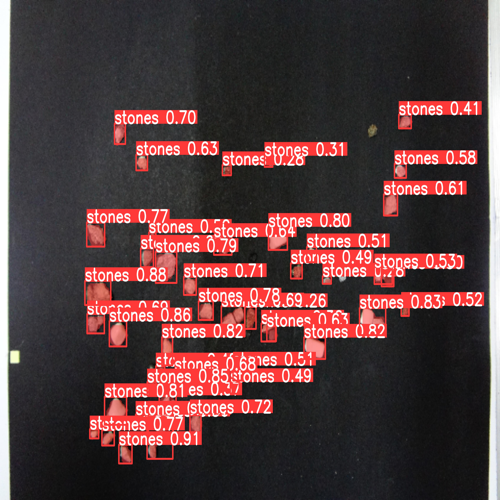

In [ ]:
Image.open('runs/segment/predict/Image12.JPG').resize((500, 500))